# Load documents with IDs

In [1]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

# Load ground truth

In [3]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [4]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [5]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

# Index data

In [6]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [8]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:57<00:00, 16.46it/s]


# Retrieval

In [9]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [10]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

# The RAG flow

In [11]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [17]:
from openai import OpenAI

client = OpenAI(api_key=key)

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [18]:
# previously: rag(query: str) -> str
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [19]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [20]:
rag(ground_truth[10]) #llm-answer

'Yes, sessions are recorded if you miss one. You can watch the recorded sessions and ask questions for office hours in advance. Additionally, you can ask questions in Slack.'

In [21]:
doc_idx['5170565b']['text']#ground-truth-answer

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

# Cosine similarity metric

In [22]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

np.float32(0.7591172)

We can compare the answer_llm and answer_orig for each of the record and compare in a similar way, to assess each model/prompt's performance:

In [ ]:
answers = {}

for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
# save the results 
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

import pandas as pd

df_gpt4o = pd.DataFrame(results_gpt4o)

df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

### Evaluating GPT 3.5

In [24]:
rag(ground_truth[10], model='gpt-3.5-turbo')

'No, sessions are recorded so if you miss one, you can still watch the recording and not miss anything.'

In [25]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

# parallel processing
def map_progress(pool, seq, f):
    '''
    seq: sequence
    f: function to exec
    '''
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [26]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

## Compare original answer to synthetic answer, GPT 4o vs GPT 3.5

original answer(A) --> generated question --> generated answer(A')  
do cosine(A, A')

In [31]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [28]:
gtp4o_result = '04-monitoring/data/results-gpt4o.csv'
gpt4o_url = f'{base_url}/{gtp4o_result}?raw=1'
df_gpt4o = pd.read_csv(gpt4o_url)

In [30]:
df_gpt4o[:3]

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp


In [32]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)


df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:54<00:00, 10.49it/s]


count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [33]:
gtp35_result = '04-monitoring/data/results-gpt35.csv'
gpt35_url = f'{base_url}/{gtp35_result}?raw=1'
df_gpt35 = pd.read_csv(gpt35_url)

results_gpt35 = df_gpt35.to_dict(orient='records')

similarity = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity.append(sim)


df_gpt35['cosine'] = similarity
df_gpt35['cosine'].describe()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:13<00:00, 13.71it/s]


count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

/tmp/ipykernel_9269/1119105052.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/tmp/ipykernel_9269/1119105052.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='3.5')


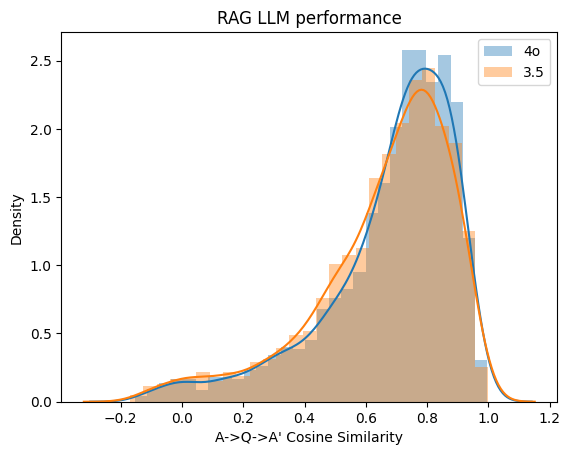

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt35['cosine'], label='3.5')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM as a judge

In [35]:

prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [36]:
df_sample = df_gpt4o.sample(n=150, random_state=1)
samples = df_sample.to_dict(orient='records')


evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [04:30<00:00,  1.81s/it]


In [38]:
import json
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [39]:
df_evaluations = pd.DataFrame(json_evaluations)

In [40]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           126
PARTLY_RELEVANT     16
NON_RELEVANT         8
Name: count, dtype: int64

In [41]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
11,NON_RELEVANT,The generated answer does not address the spec...
41,NON_RELEVANT,The generated answer is completely unrelated t...
58,NON_RELEVANT,The generated answer contradicts the original ...
81,NON_RELEVANT,The generated answer provides information abou...
90,NON_RELEVANT,The generated answer does not address the ques...
93,NON_RELEVANT,The generated answer completely misses the con...
116,NON_RELEVANT,The generated answer discusses the recommended...
139,NON_RELEVANT,The generated answer does not address the orig...


In [43]:
samples[11]

{'answer_llm': "To resolve the `NotSupportedError` in section 5, the FAQ database unfortunately does not provide specific details on this error or its solution. However, based on the structure and examples of resolving similar issues in other sections, here are the general steps you might consider:\n\n1. **Check Your Error Message in Detail**: Look for additional information in the error message that might indicate specific causes.\n\n2. **Consult Documentation**: Review the relevant section of the course materials or the official documentation for the tools or libraries you are using. They often include troubleshooting tips.\n\n3. **Update or Downgrade Dependencies**: Often errors like these are related to version incompatibility. Ensure all your dependencies are compatible. You may need to upgrade or downgrade specific packages. For instance, if you're using TensorFlow Serving, make sure its version matches the versions of other related packages.\n\n4. **Environment Setup**: Ensure y